# Analisi dati qualità dell'aria in Lombardia

Questo notebook mira ad analizzare i dati dei sensori per la qualità dell'aria in Lombardia, i dati utilizzati vengono dal portale `dati.lombardia.it` e sono i seguenti
- [Dati dei sensori](https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria/nicp-bhqi)
- [Posizione e altri dati dei sensori](https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt)

![immagine](http://www.inquinamento-italia.com/wp-content/uploads/2017/11/z987989.jpg)

# Importazione dei dati e delle librerie

Per il progetto è stata utilizzata la libreria [pandas](https://pandas.pydata.org/) che semplifica parecchio l'organizzazione e la manipolazione dei dati

La libreria [folium](https://python-visualization.github.io/folium/) ci permette invece di creare delle mappe sulle quale metteremo i dati


In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium

sensors_data = pd.read_csv("https://www.dati.lombardia.it/api/views/nicp-bhqi/rows.csv?accessType=DOWNLOAD")
sensors_location = pd.read_csv("https://www.dati.lombardia.it/api/views/ib47-atvt/rows.csv?accessType=DOWNLOAD")

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# Pulizia dei dati

Il dataset contenente tutte le misurazioni dei sensori contiene dei dati invalidi che andranno rimossi (quelli con valore -9999.0, come specificato nella pagina del dataset)

Ho inoltre convertito le date da string a datetime in modo da poter lavorare con le date facilmente


In [103]:
sensors_data = sensors_data[sensors_data["Valore"]!=-9999.0]
sensors_data["ParsedDate"] = pd.to_datetime(sensors_data["Data"],format="%d/%m/%Y %H:%M:%S %p")

# Filtraggio e analisi

Nella cella seguente viene chiesta in input una data nel formato GG/MM dalla quale verrà ricavato un dataframe contenente solo la mediana delle rilevazioni fatte in quel giorno per tutti i sensori 

In [104]:
choice = input("Inserire il giorno per il quale si vogliono visualizzare i dati nel formato gg/mm")
date = datetime.datetime.strptime(choice,"%d/%m")

filtered_data = sensors_data[(sensors_data.ParsedDate.dt.day==date.day) & (sensors_data.ParsedDate.dt.month == date.month)]
grouped_data = filtered_data.groupby(["IdSensore"]).median()
merged = grouped_data.merge(sensors_location,on=["IdSensore"])
merged = merged.drop(["DataStart","DataStop","idOperatore"],axis=1)


# Rappresentazione

La cella seguente invece crea una mappa utilizzando la libreria `folium`, la mappa sarà divisa in diversi layer in base al tipo di sensore e il colore dei marker su di essa si baserà sul valore medio misurato dal sensore durante il giorno

In [105]:
unique_sensors = merged["NomeTipoSensore"].unique()

bins_groups = merged.groupby(["NomeTipoSensore"])["Valore"].transform(pd.cut,bins=5,labels=['lightgreen', 'orange', 'red', 'purple', 'darkred'])

merged["MarkerColor"] = bins_groups
m = folium.Map(location=[45.585556, 9.930278],
               tiles="Stamen Terrain", zoom_start=9)

feature_groups = {
    x: folium.FeatureGroup(name=x).add_to(m) for x in unique_sensors
}


for sensor in merged.itertuples():
    folium.Marker(
        location=[sensor.lat, sensor.lng],
        popup=f"Id sensore : {sensor.IdSensore}\nTipo sensore : {sensor.NomeTipoSensore}\nvalore medio registrato : {sensor.Valore}{sensor.UnitaMisura}",
        icon=folium.Icon(color=sensor.MarkerColor),
    ).add_to(feature_groups[sensor.NomeTipoSensore])

folium.LayerControl().add_to(m)

m


# Grafici

I seguenti grafici rappresentano rispettivamente il numero di sensori per tipologia di dato rilevato e, dato un tipo di sensore, i dati di tutti i sensori di quel tipo rilevati durante tutto l'anno.

<AxesSubplot:ylabel='NomeTipoSensore'>

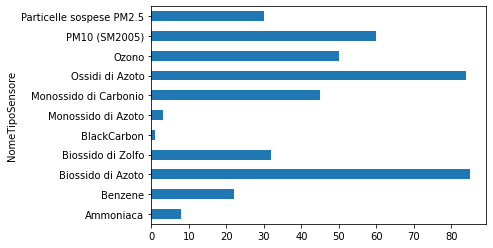

In [106]:
merged.groupby(["NomeTipoSensore"]).size().plot(kind="barh")


<AxesSubplot:title={'center':"Ammoniaca rilevato lungo tutto l'anno"}, xlabel='ParsedDate'>

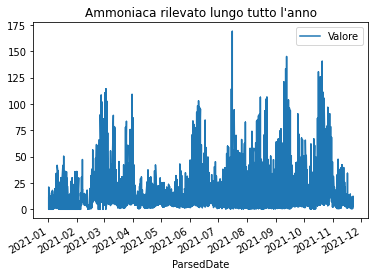

In [107]:
sensor = input(", ".join(unique_sensors))

sensors_location[sensors_location.NomeTipoSensore==sensor].merge(sensors_data).plot(x='ParsedDate',y="Valore",title=f"{sensor} rilevato lungo tutto l'anno")